In [330]:
%pip install pandas numpy matplotlib yfinance pyportfolioopt scikit-learn
import os

Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  1 of 1 completed


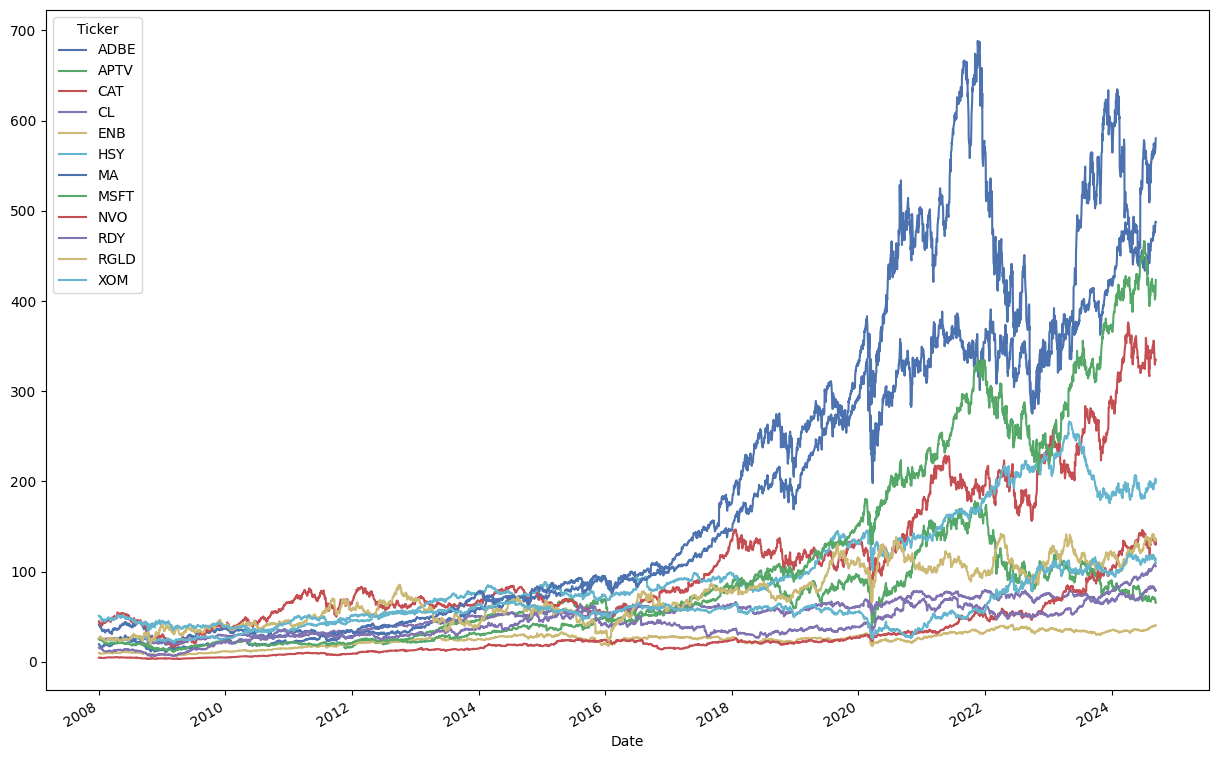

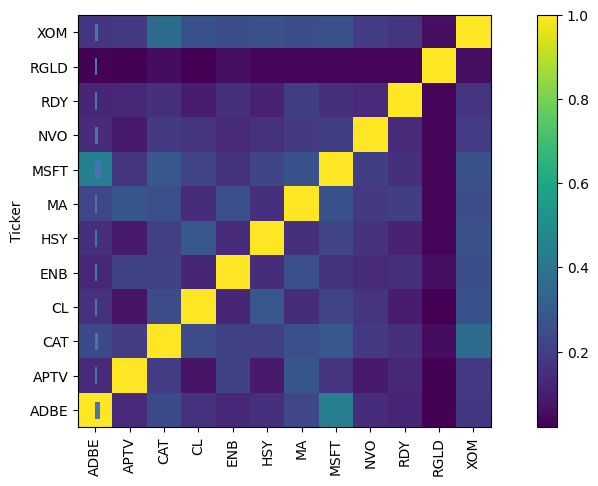

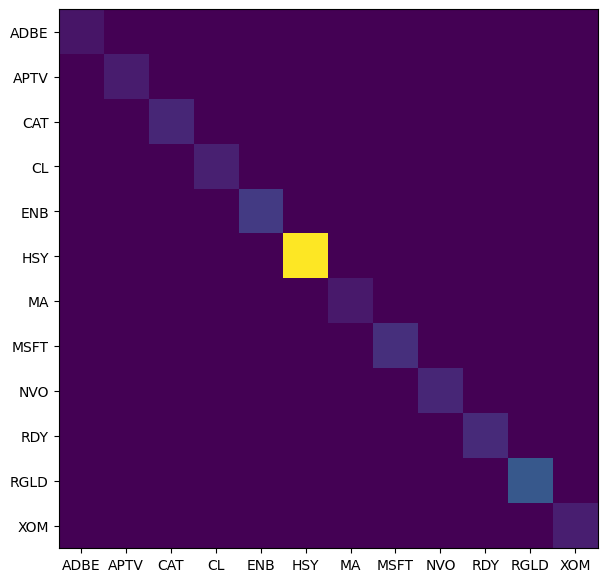

[0.004900000000000001, 0.019599999999999996, 0.0036000000000000008, 0.010000000000000002, 0.0025000000000000005, 0.0006250000000000004, 0.0025000000000000005, 0.00039999999999999986, 0.0025000000000000005, 0.0015999999999999994, 0.0004000000000000002, 0.0016000000000000007]
Leftover: $47.07
Expected annual return: 15.6%
Annual volatility: 14.4%
Sharpe Ratio: 0.94


c:\Users\ywpok\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


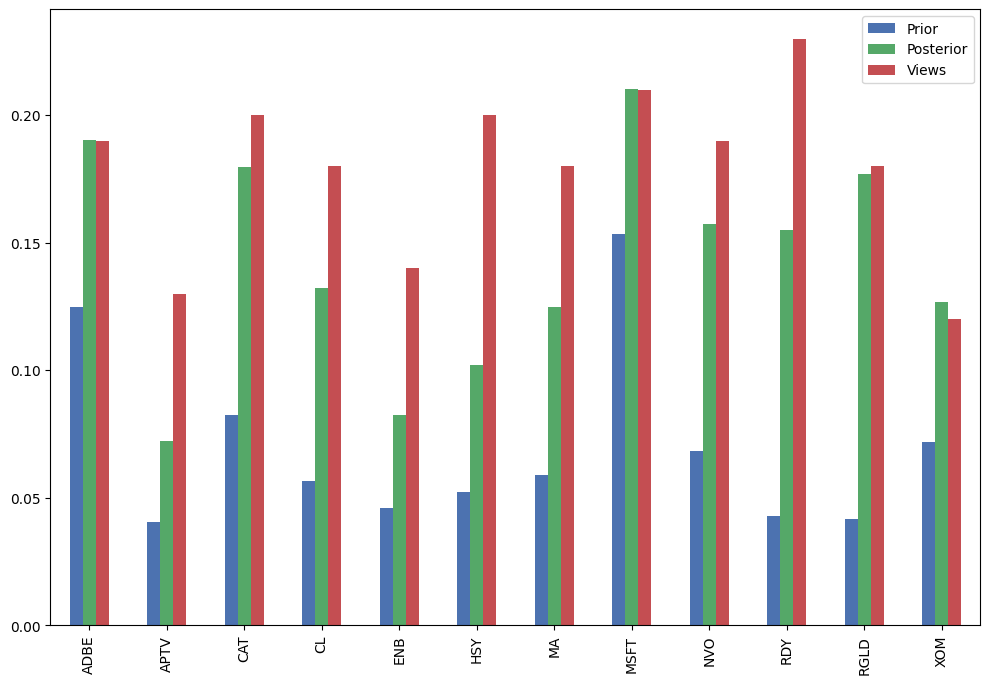

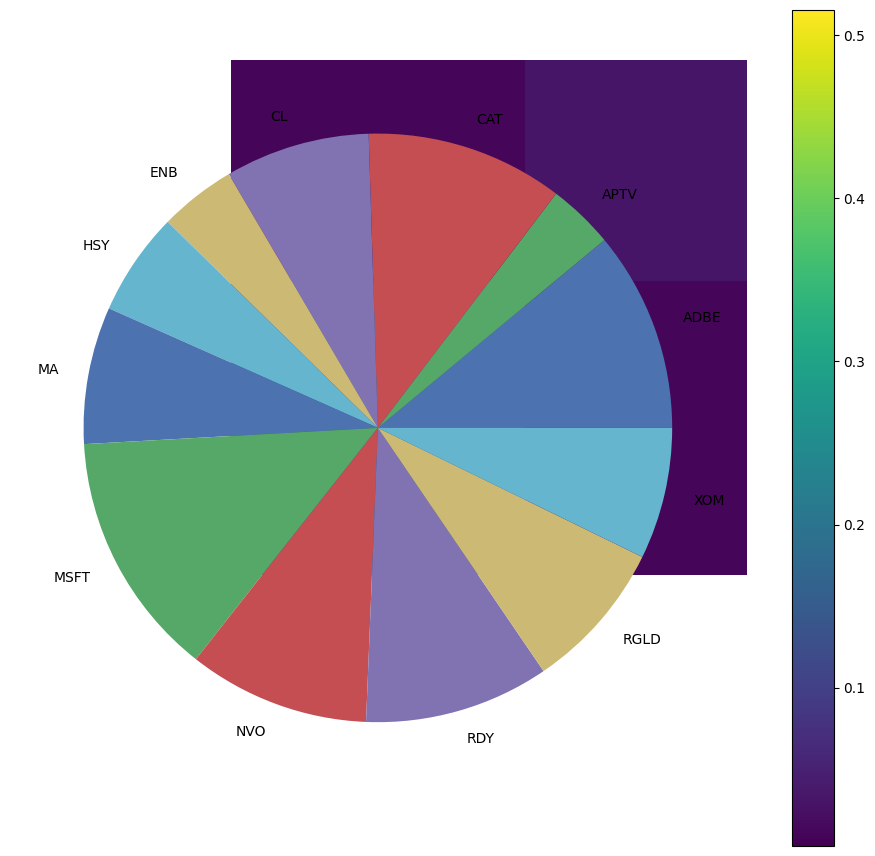

In [331]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp
tickers = ["MSFT", "APTV", "CL", "ENB", "CAT", "HSY", "RGLD", "MA", "XOM", "NVO", "ADBE", "RDY"]
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps
import pypfopt
pypfopt.__version__
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta
plotting.plot_covariance(S, plot_correlation=True);
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior
market_prior.plot.barh(figsize=(10,5));
# You don't have to provide views on all the assets
viewdict = {
    "APTV": 0.13,
    "ENB": 0.14,
    "XOM": 0.12,
    "HSY": 0.20,
    "CAT": 0.20,
    "RGLD": 0.18,  # I think Coca-Cola will go down 5%
    "MA": 0.18,
    "MSFT": 0.21,
    "CL": 0.18,  # but low confidence, which will be reflected later
    "NVO": 0.19,
    "ADBE": 0.19,
    "RDY": 0.23
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)
confidences = [
    0.9,
    0.87,
    0.6,
    0.5,
    0.7,
    0.7,
    0.7,
    0.8,
    0.7,
    0.8,
    0.75,
    0.7
]
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()
np.diag(bl.omega)
intervals = [
    (0, 0.14),
    (0.02, 0.3),
    (0.11, 0.23),
    (0.07, 0.27),
    (0.15, 0.25),
    (0.15, 0.20),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.22, 0.32),
    (0.1, 0.18),
    (0.13, 0.17),
    (0.19, 0.27)
]
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df
rets_df.plot.bar(figsize=(12,8));
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);
from pypfopt import EfficientFrontier, objective_functions
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights
pd.Series(weights).plot.pie(figsize=(10,10));
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc
ef.portfolio_performance(verbose=True);

We use yfinance to download historical price data for a diverse set of 12 stocks across various sectors. The data is processed to extract adjusted closing prices for subsequent calculations.

In [332]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import cvxpy as cp

In [333]:
tickers = ["MSFT", "APTV", "CL", "ENB", "CAT", "HSY", "RGLD", "MA", "XOM", "NVO", "ADBE", "RDY"]

In [334]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  12 of 12 completed


Ticker,ADBE,APTV,CAT,CL,ENB,HSY,MA,MSFT,NVO,RDY,RGLD,XOM
Date,,,,,,,,,,,,
2024-09-05 00:00:00+00:00,567.929993,70.970001,333.559998,108.529999,40.450001,198.100006,477.359985,408.390015,130.889999,79.639999,137.529999,113.169998
2024-09-06 00:00:00+00:00,563.409973,68.489998,329.359985,107.860001,40.389999,199.800003,476.119995,401.700012,131.139999,79.199997,134.039993,112.639999
2024-09-09 00:00:00+00:00,569.880005,69.080002,334.040009,107.110001,40.790001,203.250000,487.089996,405.720001,131.910004,79.610001,134.929993,115.010002
2024-09-10 00:00:00+00:00,574.479980,65.379997,334.160004,106.839996,40.259998,202.830002,488.019989,414.200012,129.779999,78.889999,136.080002,110.820000
2024-09-11 00:00:00+00:00,580.380005,65.550003,334.997498,106.089996,40.240002,198.580902,487.890015,423.329987,135.214996,79.320000,136.550003,109.709999


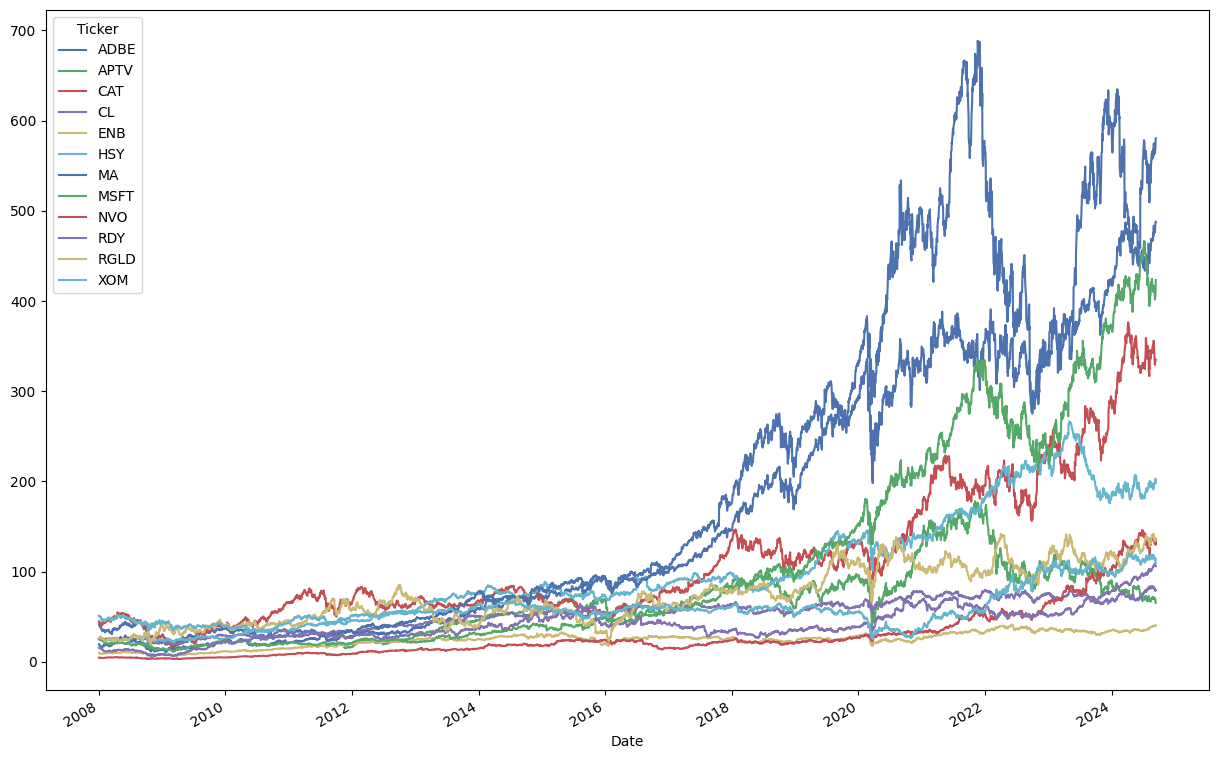

In [335]:
prices[prices.index >= "2008-01-01"].plot(figsize=(15,10));

In [336]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    24.684101
1993-02-01    24.859673
1993-02-02    24.912338
1993-02-03    25.175678
1993-02-04    25.281013
Name: Adj Close, dtype: float64

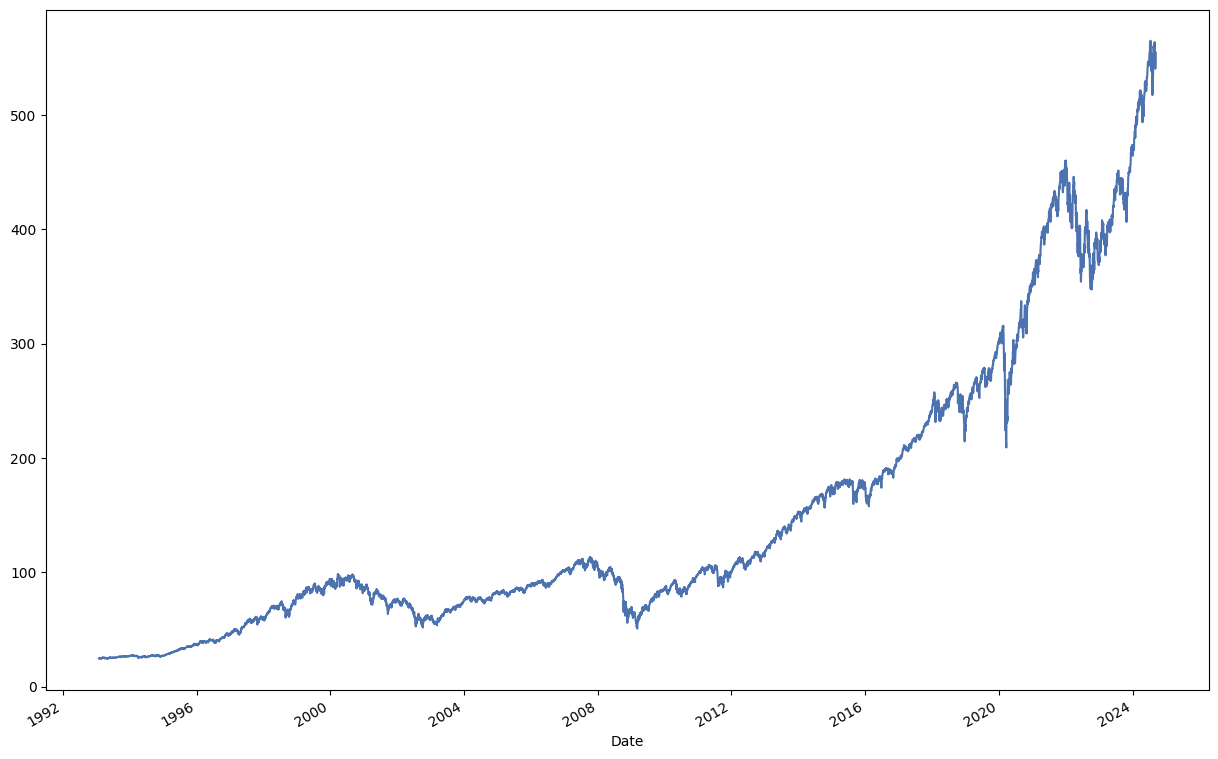

In [337]:
market_prices.plot(figsize=(15,10));

In [338]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 3146628726784,
 'APTV': 15401628672,
 'CL': 86684753920,
 'ENB': 87836278784,
 'CAT': 162439610368,
 'HSY': 40170532864,
 'RGLD': 8976920576,
 'MA': 450729869312,
 'XOM': 487422853120,
 'NVO': 600343773184,
 'ADBE': 257340489728,
 'RDY': 13266507776}

## Constructing the prior

In [339]:
import pypfopt
pypfopt.__version__

'1.5.5'

We calculate market-implied returns using market capitalization and implement the Ledoit-Wolf shrinkage method for covariance estimation.

In [340]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.755955513626534

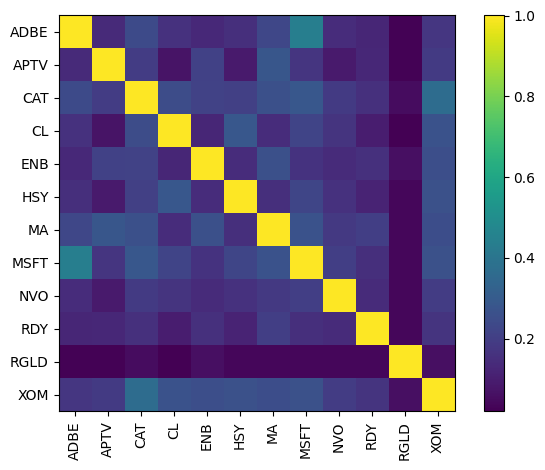

In [341]:
plotting.plot_covariance(S, plot_correlation=True);

In [342]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

Ticker
ADBE    0.124693
APTV    0.040698
CAT     0.082502
CL      0.056439
ENB     0.045936
HSY     0.052339
MA      0.058943
MSFT    0.153592
NVO     0.068432
RDY     0.042698
RGLD    0.041711
XOM     0.071810
dtype: float64

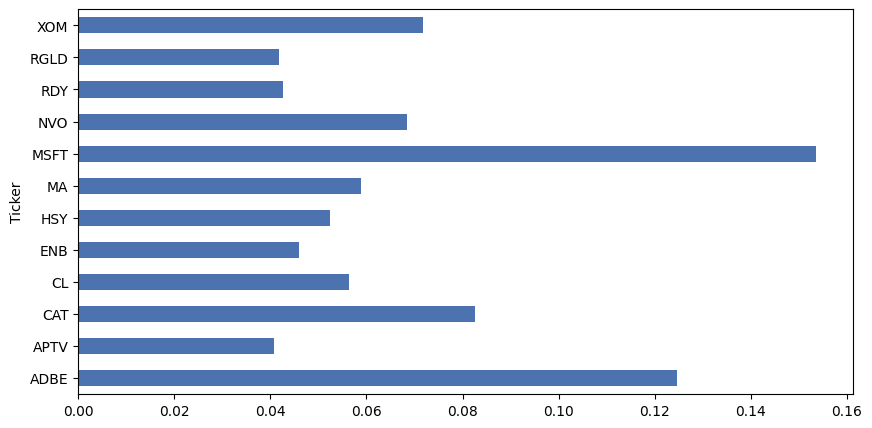

In [343]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [344]:
# You don't have to provide views on all the assets
viewdict = {
    "APTV": 0.13,
    "ENB": 0.14,
    "XOM": 0.12,
    "HSY": 0.18,
    "CAT": 0.12,
    "RGLD": 0.18,
    "MA": 0.18,
    "MSFT": 0.21,
    "CL": 0.18,  # but low confidence, which will be reflected later
    "NVO": 0.19,
    "ADBE": 0.19,
    "RDY": 0.23
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [345]:
confidences = [
    0.9,
    0.87,
    0.6,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7,
    0.8,
    0.7,
    0.8,
    0.75,
    0.7
]

In [346]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

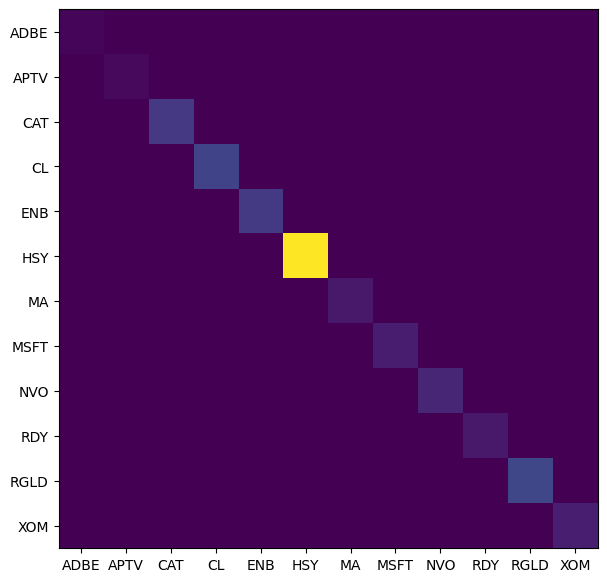

In [347]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [348]:
np.diag(bl.omega)

array([0.00016692, 0.00029572, 0.0018145 , 0.00224004, 0.00187431,
       0.01103633, 0.0007418 , 0.00087553, 0.00117599, 0.00075625,
       0.00235001, 0.00092963])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [349]:
intervals = [
    (0, 0.14),
    (0.02, 0.3),
    (0.11, 0.23),
    (0.07, 0.27),
    (0.15, 0.25),
    (0.15, 0.20),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.22, 0.32),
    (0.1, 0.18),
    (0.13, 0.17),
    (0.19, 0.27)
]


In [350]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.004900000000000001, 0.019599999999999996, 0.0036000000000000008, 0.010000000000000002, 0.0025000000000000005, 0.0006250000000000004, 0.0025000000000000005, 0.00039999999999999986, 0.0025000000000000005, 0.0015999999999999994, 0.0004000000000000002, 0.0016000000000000007]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [351]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [352]:
# Normalize stock data based on initial price
def normalize(df):
  x = df.copy()
  for i in x.columns[1:]:
    x[i] = x[i]/x[i][0]
  return x

In [353]:
# Function to plot interactive plot
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns[1:]:
    fig.add_scatter(x = df['Date'], y = df[i], name = i)
  fig.show()

In [354]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
ADBE    0.189700
APTV    0.069631
CAT     0.131847
CL      0.128606
ENB     0.078653
HSY     0.096137
MA      0.121922
MSFT    0.209609
NVO     0.155908
RDY     0.153685
RGLD    0.177048
XOM     0.120126
dtype: float64

We can visualise how this compares to the prior and our views:

In [355]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
ADBE,0.124693,0.189700,0.19
APTV,0.040698,0.069631,0.13
CAT,0.082502,0.131847,0.12
CL,0.056439,0.128606,0.18
ENB,0.045936,0.078653,0.14
HSY,0.052339,0.096137,0.18
MA,0.058943,0.121922,0.18
MSFT,0.153592,0.209609,0.21
NVO,0.068432,0.155908,0.19
RDY,0.042698,0.153685,0.23


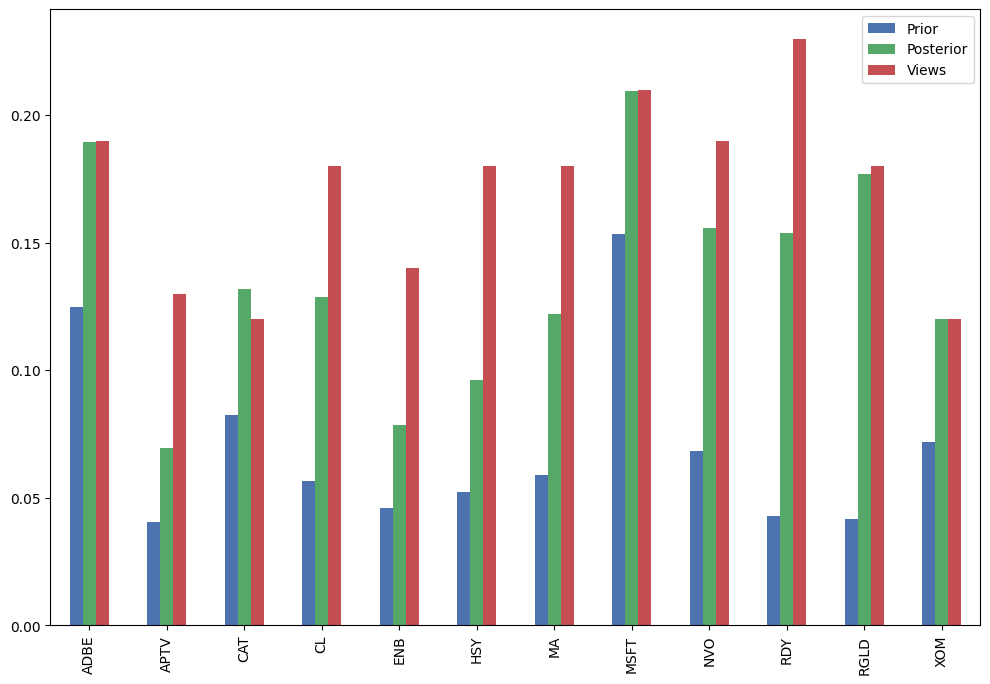

In [356]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

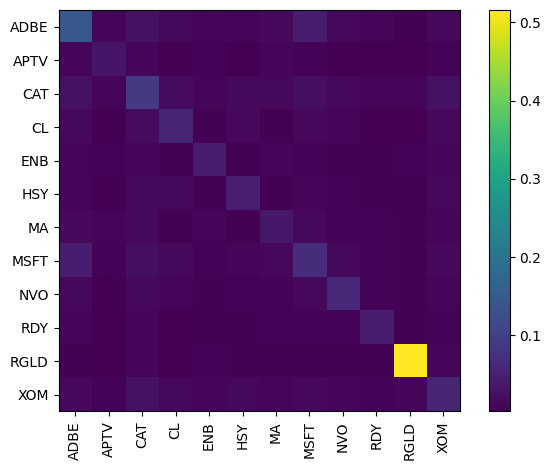

In [357]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [358]:
from pypfopt import EfficientFrontier, objective_functions

In [359]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

c:\Users\ywpok\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('ADBE', 0.11704),
             ('APTV', 0.03654),
             ('CAT', 0.07623),
             ('CL', 0.08184),
             ('ENB', 0.04178),
             ('HSY', 0.05548),
             ('MA', 0.07779),
             ('MSFT', 0.14294),
             ('NVO', 0.10456),
             ('RDY', 0.1066),
             ('RGLD', 0.08743),
             ('XOM', 0.07178)])

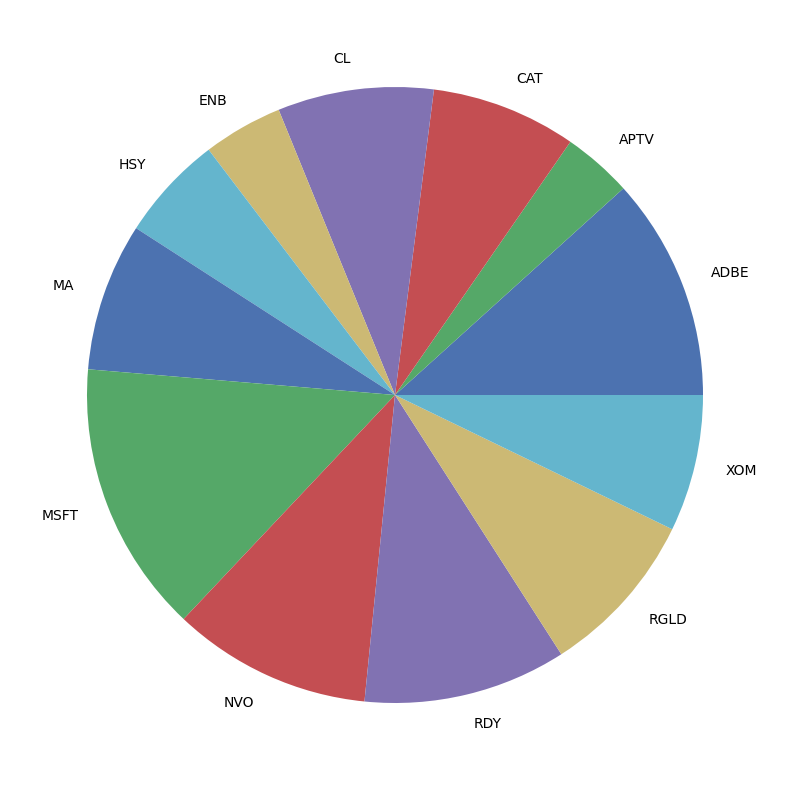

In [360]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [361]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=100000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $32.50


{'ADBE': 20,
 'APTV': 56,
 'CAT': 23,
 'CL': 77,
 'ENB': 103,
 'HSY': 28,
 'MA': 16,
 'MSFT': 34,
 'NVO': 77,
 'RDY': 134,
 'RGLD': 64,
 'XOM': 65}

In [362]:
ef.portfolio_performance(verbose=True);

Expected annual return: 15.0%
Annual volatility: 14.5%
Sharpe Ratio: 0.90


In [363]:
from pypfopt import expected_returns
from pypfopt import EfficientSemivariance

# Use the full price dataframe, not just the tail
df = prices  # your dataframe of prices

# Calculate expected returns
mu = expected_returns.mean_historical_return(df) 
# Calculate historical returns
historical_returns = expected_returns.returns_from_prices(df)

# Create the EfficientSemivariance object
es = EfficientSemivariance(mu, historical_returns)

# Optimize for a target return of 20%
es.efficient_return(target_return=0.20)

# Get the optimized weights
weights = es.clean_weights()
print("Optimized weights:")
print(weights)

# Display portfolio performance
print("\nPortfolio Performance:")
es.portfolio_performance(verbose=True)

c:\Users\ywpok\AppData\Local\Programs\Python\Python312\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:149: UserWarning: Removing NaNs from returns
  warnings.warn(


Optimized weights:
OrderedDict({'ADBE': 0.0, 'APTV': 0.0, 'CAT': 0.0, 'CL': 0.09862, 'ENB': 0.0, 'HSY': 0.24486, 'MA': 0.23517, 'MSFT': 0.14771, 'NVO': 0.15995, 'RDY': 0.074, 'RGLD': 0.0397, 'XOM': 0.0})

Portfolio Performance:
Expected annual return: 20.0%
Annual semi-deviation: 10.8%
Sortino Ratio: 1.66


(0.20000011219438654, 0.10812421975981766, 1.6647529350429608)